# Conformalized Early Stopping -- Multi-class Classification
__The notebook is organized in the following parts:__
1. Training and conformalized early stopping: we train a CNN with CIFAR10 dataset, save model snapshots regularly. 
2. Compute conformal prediction sets:  For each test point we select the best snapshots from the model list saved at step 1. We then compute marginal and label conditional prediction sets using the best model.
3. Visualization and comparison with benchmark: lastly we will compare our new method to the conventional benchmark approach and visualize the difference.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def get_image(img):
    """
    convert a tensor to images suitable for plotting
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    return np.transpose(npimg, (1, 2, 0))

def plot_loss_acc(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc):
    x = np.arange(1, len(train_loss) + 1)

    fig,axs = plt.subplots(1, 2, figsize=(16,6))
    axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    axs[0].plot(x, test_loss, color=colors[2], label="Test loss", linewidth=2)
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='upper right')
    axs[0].set_title("Evolution of the training, validation and test loss")

    axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
    axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
    axs[1].plot(x, test_acc, color=colors[2], label="Test accuracy", linewidth=2)
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(loc='lower right')
    axs[1].set_title("Evolution of the training, validation and test accuracy")
    plt.show()


###  Loading and normalizing CIFAR10 Dataset


In [3]:
import numpy as np
import tensorflow
import torch as th
import torchvision
import torchvision.transforms as transforms

### Define subset of the dataset (so it is faster to train)

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 1000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [5]:
num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = th.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = th.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

     truck      truck        car      horse


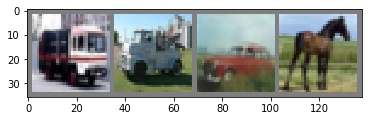

In [7]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

## Train CNN

In [8]:
import sys, os
import torch.nn as nn
import torch.nn.functional as F

In [9]:
sys.path.append('../ConformalizedES')
sys.path.append('../third_party')

In [10]:
from method import CES_multiClass
from networks import SimpleConvolutionalNetwork
from inference import Conformal_PSet

In [11]:
net = SimpleConvolutionalNetwork()

In [12]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [13]:
# Define the model parameters

lr = 0.001
n_epoch = 10
n_classes = len(classes)
batch_size = 64

criterion, optimizer = createLossAndOptimizer(net, learning_rate=lr)

In [14]:
seed = 2022
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")### Define subset of the dataset (so it is faster to train)

In [15]:
def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

train_loader = get_train_loader(batch_size)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=1000, sampler=val_sampler,
                                          num_workers=num_workers)

test_loader = th.utils.data.DataLoader(test_set, batch_size=1000, sampler=test_sampler,
                                         num_workers=num_workers)

In [16]:
seed = 2023
np.random.seed(seed)
th.manual_seed(seed)

# Initialize the CES class with model parameters
CES_mc = CES_multiClass(net, device, train_loader, n_classes=n_classes, batch_size=batch_size, max_epoch=n_epoch, 
                        learning_rate=lr, val_loader=val_loader, criterion=criterion,optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 10
learning_rate= 0.001


In [17]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_mc.full_train(save_dir = './models', save_every = save_every)

Epoch 1 of 10, 10% 	 train_loss: 2.15 train_acc: 24.40% took: 0.55s
Epoch 1 of 10, 20% 	 train_loss: 1.95 train_acc: 34.78% took: 0.44s
Epoch 1 of 10, 30% 	 train_loss: 1.81 train_acc: 38.56% took: 0.46s
Epoch 1 of 10, 40% 	 train_loss: 1.74 train_acc: 41.23% took: 0.46s
Epoch 1 of 10, 51% 	 train_loss: 1.73 train_acc: 42.29% took: 0.44s
Epoch 1 of 10, 61% 	 train_loss: 1.68 train_acc: 44.56% took: 0.45s
Epoch 1 of 10, 71% 	 train_loss: 1.66 train_acc: 43.60% took: 0.44s
Epoch 1 of 10, 81% 	 train_loss: 1.59 train_acc: 46.22% took: 0.46s
Epoch 1 of 10, 92% 	 train_loss: 1.55 train_acc: 47.03% took: 0.43s
val_loss = 1.44 val_acc = 48.24%
Snapshot saved at epoch 1.
Epoch 2 of 10, 10% 	 train_loss: 1.45 train_acc: 53.18% took: 0.52s
Epoch 2 of 10, 20% 	 train_loss: 1.49 train_acc: 49.80% took: 0.43s
Epoch 2 of 10, 30% 	 train_loss: 1.50 train_acc: 49.80% took: 0.44s
Epoch 2 of 10, 40% 	 train_loss: 1.42 train_acc: 53.12% took: 0.43s
Epoch 2 of 10, 51% 	 train_loss: 1.41 train_acc: 51.81% 

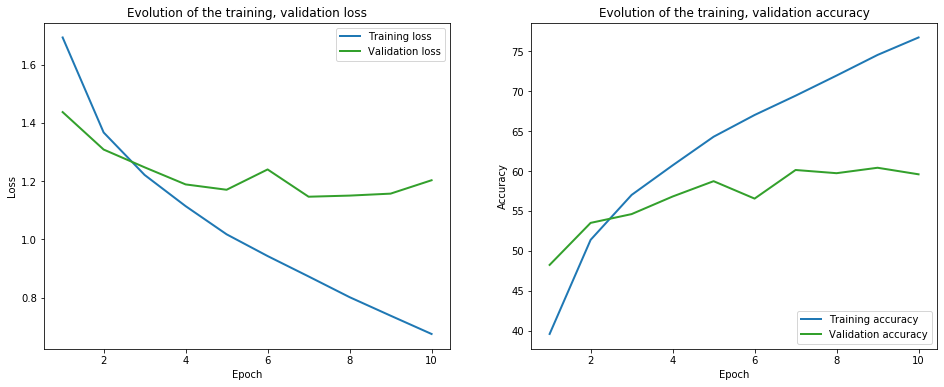

In [18]:
train_loss = CES_mc.train_loss_history
train_acc = CES_mc.train_acc_history
val_loss = CES_mc.val_loss_history
val_acc = CES_mc.val_acc_history


x = np.arange(1, len(train_loss) + 1)

fig,axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
axs[0].plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')
axs[0].set_title("Evolution of the training, validation loss")

axs[1].plot(x, train_acc, color=colors[0], label="Training accuracy", linewidth=2)
axs[1].plot(x, val_acc, color=colors[1], label="Validation accuracy", linewidth=2)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='lower right')
axs[1].set_title("Evolution of the training, validation accuracy")
plt.show()

# Select best models and compute prediction sets


## Check the benchmark model
select_model function will choose the best model for given test point, if no test point
is given, it will output the best model selected ONLY based on validation data, which
serves as an benchmark model.

In [19]:
# check the benchmark model
bm_loss, bm_model, loss_history = CES_mc.select_model()

In [20]:
# Benchmark model corresponds to the one with smallest validation loss
print('Benchmark best loss is: {:.3f}'.format(bm_loss))
print('Benchmark best model is saved in:', bm_model)

Benchmark best loss is: 1.147
Benchmark best model is saved in: ['./models/model7.pth']


# Compute prediction sets

In [21]:
from inference import Conformal_PSet

alpha = 0.1
n_classes = len(classes)
model_list = CES_mc.model_list     # Get the saved model list from the CES class

# Compute conformity scores of calibration sets for each model and corresponding calibrated
# confidence level, this might take some time if we have too many saved models but fortunately
# this initialization will be a one-time effort.
cal_time = time.time()
C_PSet = Conformal_PSet(net, device, val_loader, n_classes, model_list, alpha,random_state = 2023)
print('Calibration (one time effort) takes:{:.2f}s.'.format(time.time()-cal_time))

  0%|          | 0/10 [00:00<?, ?it/s]

Calibrating each model in the list...


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

Initialization done!
Calibration (one time effort) takes:8.83s.


In [32]:
# get all test images
dataiter = iter(test_loader)
inputs, labels = dataiter.next()

In [34]:
# Pick the best model for each test point
start = time.time()
best_loss, best_model, test_val_loss_history = CES_mc.select_model(inputs)
print('selecting models takes:', time.time()-start)

Loading model 0 of 10...


100%|██████████| 1000/1000 [00:07<00:00, 128.32it/s]

Loading model 1 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 131.73it/s]

Loading model 2 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 129.25it/s]

Loading model 3 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 130.57it/s]

Loading model 4 of 10...



100%|██████████| 1000/1000 [00:08<00:00, 120.20it/s]

Loading model 5 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 125.01it/s]

Loading model 6 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 128.70it/s]

Loading model 7 of 10...



100%|██████████| 1000/1000 [00:08<00:00, 121.78it/s]

Loading model 8 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 130.63it/s]

Loading model 9 of 10...



100%|██████████| 1000/1000 [00:07<00:00, 131.15it/s]

selecting models takes: 78.4024646282196


In [36]:
# Get the marginal conformal pvalues 
pset_m= C_PSet.pred_set(inputs, best_model, marginal=True)
# Get the label conditional conformal pvalues 
pset_lc = C_PSet.pred_set(inputs, best_model, marginal=False)

  1%|          | 6/1000 [00:00<00:17, 57.60it/s]

Finished computing marginal prediction sets for 1000 test points.


100%|██████████| 1000/1000 [00:15<00:00, 64.58it/s]

Finished computing label conditional prediction sets for 1000 test points.


In [37]:
def evaluate_predictions(S, y):
    coverage = np.mean([y[i] in S[i] for i in range(len(y))])
    length = np.mean([len(S[i]) for i in range(len(y))])
    idx_cover = np.where([y[i] in S[i] for i in range(len(y))])[0]
    length_cover = np.mean([len(S[i]) for i in idx_cover])
    return coverage, length, length_cover

def evaluate_marginal(S, y):
    coverage, length, length_cover = evaluate_predictions(S, y)
    print('Marginal coverage:       {:2.3%}'.format(coverage))
    print('Average size:            {:2.3f}'.format(length))
    print('Average size | coverage: {:2.3f}'.format(length_cover))

def evaluate_conditional(S, y):
    n_class = len(np.unique(y))
    for i in range(n_class):
        label = i
        idx = np.where(y==label)[0]
        coverage, length, length_cover = evaluate_predictions(np.array(S, dtype=object)[idx], np.array(y)[idx])
        print('Conditional coverage for label {}:       {:2.3%}'.format(classes[label], coverage))
        print('Average size:            {:2.3f}'.format(length))
        print('Average size | coverage: {:2.3f}'.format(length_cover))

In [38]:
print('Evaluate marginal prediction sets.')
print('='*50)
evaluate_marginal(pset_m, labels.numpy())
print('='*50)
evaluate_conditional(pset_m, labels.numpy())

Evaluate marginal prediction sets.
Marginal coverage:       92.100%
Average size:            3.111
Average size | coverage: 3.115
Conditional coverage for label plane:       93.204%
Average size:            2.951
Average size | coverage: 2.833
Conditional coverage for label car:       93.258%
Average size:            2.382
Average size | coverage: 2.337
Conditional coverage for label bird:       87.000%
Average size:            3.610
Average size | coverage: 3.805
Conditional coverage for label cat:       89.320%
Average size:            3.942
Average size | coverage: 3.978
Conditional coverage for label deer:       90.000%
Average size:            3.689
Average size | coverage: 3.753
Conditional coverage for label dog:       95.349%
Average size:            3.337
Average size | coverage: 3.390
Conditional coverage for label frog:       98.214%
Average size:            2.768
Average size | coverage: 2.755
Conditional coverage for label horse:       88.235%
Average size:            2.97

In [39]:
print('Evaluate label conditional prediction sets.')
print('='*50)
evaluate_marginal(pset_lc, labels.numpy())
print('='*50)
evaluate_conditional(pset_lc, labels.numpy())

Evaluate label conditional prediction sets.
Marginal coverage:       91.100%
Average size:            3.078
Average size | coverage: 3.106
Conditional coverage for label plane:       87.379%
Average size:            2.981
Average size | coverage: 2.933
Conditional coverage for label car:       87.640%
Average size:            2.315
Average size | coverage: 2.346
Conditional coverage for label bird:       90.000%
Average size:            3.630
Average size | coverage: 3.733
Conditional coverage for label cat:       90.291%
Average size:            3.913
Average size | coverage: 3.968
Conditional coverage for label deer:       90.000%
Average size:            3.556
Average size | coverage: 3.617
Conditional coverage for label dog:       94.186%
Average size:            3.395
Average size | coverage: 3.469
Conditional coverage for label frog:       92.857%
Average size:            2.812
Average size | coverage: 2.808
Conditional coverage for label horse:       91.176%
Average size:       

In [40]:
C_PSet.alpha_calibrated[6]

0.061653967312097574

In [41]:
C_PSet.alpha_calibrated_lc[6]

array([0.09577756, 0.08687541, 0.0434366 , 0.04572834, 0.06119885,
       0.09531006, 0.11066121, 0.03741534, 0.05115727, 0.04441928])